##***DeepFake Detection Using Deep Learning***




This notebook was run on Kaggle Machine, therefore the setups below might not work in a local machine.

## **Setup and Library Imports**

In [1]:
import os
import torch
from torch import nn
import random
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

In [2]:
seed=40302
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
import os
os.chdir('/kaggle/input/psoscripts')

In [4]:
os.getcwd()

'/kaggle/input/psoscripts'

## **Helper Functions**

In [5]:
from src.utils import *

## **Data Reading, Splitting and Loading**

In [6]:
from src.dataset import *

In [7]:
def load_data2():

    # load datasets from csv and folders
    # 1. DFDC
    dfdc_folders = glob("/kaggle/input/deepfake-detection-faces*")
    dfdc_folders = sorted(dfdc_folders, key=lambda x: x)
    all_dataframes = []
    for train_dir in dfdc_folders:
        df = pd.read_csv(os.path.join(train_dir, "metadata.csv"))
        df["path"] = df["filename"].apply(lambda x: os.path.join(train_dir, x.split(".")[0]))
        all_dataframes.append(df)

    dfdc_df = pd.concat(all_dataframes, ignore_index=True, sort=False)
    dfdc_df["origin"] = "dfdc"
    dfdc_df.drop(["split", "original"], axis=1, inplace=True)

    # 2. CelebDF
    celeb_df = pd.read_csv("/kaggle/input/celebfaces/celeb_metadata.csv")
    celeb_df["path"] = celeb_df["Unnamed: 0"].apply(
        lambda x: os.path.join("/kaggle/input/celebfaces/CelebDF-v2/faces", x.split(".")[0])
    )
    celeb_df.drop(["img_dir", "fullpath"], axis=1, inplace=True)
    celeb_df.rename(columns={"Unnamed: 0": "filename"}, inplace=True)
    celeb_df = celeb_df[["filename", "label", "path", "origin"]]
    df2 = pd.read_csv(
        "/kaggle/input/celebfaces/CelebDF-v2/List_of_testing_videos.txt", delimiter=" ", header=None
    )
    df2[1] = df2[1].apply(lambda s: s.split("/")[-1])
    test_celeb = celeb_df.loc[celeb_df.filename.isin(df2[1].tolist())].reset_index(drop=True)
    celeb_df.drop(test_celeb.index, inplace=True)
    celeb_df.drop(celeb_df[celeb_df["filename"] == "00233.mp4"].index, inplace=True)
    celeb_df.reset_index(drop=True, inplace=True)

    # 3 . Youtube Faces Extracted
    ytf_df = pd.read_csv("/kaggle/input/youtube-faces-extracted/youtube_faces_50f.csv")
    ytf_df["label"] = "REAL"
    ytf_df["origin"] = "ytf"
    ytf_df["path"] = ytf_df["videoID"].apply(
        lambda x: os.path.join("/kaggle/input/youtube-faces-extracted/faces", x)
    )
    ytf_df.head()

    ytf_df.drop(
        [
            "Unnamed: 0",
            "personName",
            "imageHeight",
            "imageWidth",
            "videoDuration",
            "averageFaceSize",
            "numVideosForPerson",
        ],
        axis=1,
        inplace=True,
    )
    ytf_df.rename(columns={"videoID": "filename"}, inplace=True)
    ytf_df = ytf_df[["filename", "label", "path", "origin"]]
    x = [False for n in range(len(ytf_df.path))]
    for i, path in enumerate(ytf_df.path.tolist()):
        already_present_count = len(glob(path + "/*"))
        if already_present_count >= 50:
            x[i] = True
    ytf_df = ytf_df[x].reset_index(drop=True)

    # Separate test dataset before duplicate real frames from celebdf and dfdc

    df = pd.concat([dfdc_df, celeb_df, ytf_df], ignore_index=True, sort=False)
    df["frames"] = 1
    df["inv_frame"] = 0

    _, _test = get_split(df, 0.2)
    test_df = df.loc[_test, :]
    test_df.reset_index(drop=True, inplace=True)

    df.drop(_test, inplace=True)
    df.reset_index(drop=True, inplace=True)

    # get validation set before duplications.
    train_idx, val_idx = get_split(df, 0.2)
    train_df = df.loc[train_idx, :].reset_index(drop=True)
    valid_df = df.loc[val_idx, :].reset_index(drop=True)

    # duplicate data labeled real in Dfdc and Celebdf
    real_dfdc = train_df[
        (train_df["label"] == "REAL") & (train_df["origin"] == "dfdc")
    ].reset_index(drop=True)

    real_celeb = train_df[
        (train_df["label"] == "REAL") & (train_df["origin"] == "CelebDF-v2")
    ].reset_index(drop=True)

    for i in range(2, 4):
        if i <= 3:
            real_celeb.frames = i
            real_celeb_i = real_celeb.copy()
            real_celeb_i.inv_frame = 1
            train_df = pd.concat([train_df, real_celeb_i], ignore_index=True, sort=False)
        real_dfdc.frames = i
        real_dfdc_i = real_dfdc.copy()
        real_dfdc_i.inv_frame = 1
        train_df = pd.concat([train_df, real_dfdc_i], ignore_index=True, sort=False)

    # undersample fakes to have around 50-50% of training samples
    train_df.drop(
        train_df[(train_df["label"] == "FAKE") & (train_df["origin"] == "dfdc")].sample(4000).index,
        inplace=True,
    )

    train_df.drop(
        train_df[(train_df["label"] == "FAKE") & (train_df["origin"] == "CelebDF-v2")]
        .sample(1300)
        .index,
        inplace=True,
    )
    train_df.reset_index(drop=True, inplace=True)

    valid_df.drop(
        valid_df[(valid_df["label"] == "FAKE") & (valid_df["origin"] == "dfdc")].sample(1000).index,
        inplace=True,
    )

    valid_df.drop(
        valid_df[(valid_df["label"] == "FAKE") & (valid_df["origin"] == "CelebDF-v2")]
        .sample(400)
        .index,
        inplace=True,
    )
    valid_df.reset_index(drop=True, inplace=True)

    return train_df, valid_df, test_df, test_celeb

In [8]:
train_df, valid_df, test_df, test_celeb = load_data2()

## **Run training with hyperparam. obtained manually


In [9]:
from src.models.deepfake_detectors import Efficientnet_GRU_Model
from src.train_val_funcs import train_epoch, run_inference


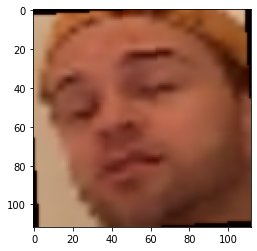

In [10]:
#preprocess the data
train_data = VideoDataset(train_df, 22, im_size=112,transform = train_transforms(112))
val_data = VideoDataset(valid_df, 22, im_size=112,transform = test_transforms(112))

#load the data into dataloaders
train_loader = DataLoader(train_data, batch_size = 8, shuffle = True, num_workers = 2)
valid_loader = DataLoader(val_data, batch_size = 8, shuffle = True, num_workers = 2)
#plot the data
image,label = train_data[1]
im_plot(image[1,:,:,:])

In [11]:
#train function for Efficient_GRU_Model
def train_epoch(epoch, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    
    for i, (inputs, targets) in pbar:
        
        targets = targets.type(torch.cuda.LongTensor)
        inputs = inputs.cuda()
        _,outputs = model(inputs)
        
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #add comment to progress bar 
        description = f'epoch {epoch} loss: {losses.avg:.4f} acc: {accuracies.avg:.2f}'   
        pbar.set_description(description)
    
    return losses.avg,accuracies.avg

#test function for Efficient_GRU_Model
def run_inference(model, data_loader ,criterion):
 #   print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(data_loader), total=len(data_loader))

        for i, (inputs, targets) in pbar:

            targets = targets.cuda().type(torch.cuda.FloatTensor)
            inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1) 
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))

            description = f' loss: {losses.avg:.4f} acc: {accuracies.avg:.2f}' 
            pbar.set_description(description)
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

In [12]:
model2 = Efficientnet_GRU_Model(2, dropout_rate=0.3, bidirectional=True).cuda()

#learning rate
lr = 1e-4
#number of epochs 
num_epochs = 20

optimizer = torch.optim.Adam(model2.parameters(), lr= lr,weight_decay = 1e-5)

criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
best_accuracy = 0
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,train_loader,model2,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = run_inference(model2,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
    if t_acc > best_accuracy:
        best_accuracy = t_acc
        torch.save(model2.state_dict(),'/kaggle/working/EfficientNet_GRU_Model_{}.pt'.format(epoch))
    

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 89.46153846153847


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 90.53846153846153


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 90.76923076923077


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 91.23076923076923


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 92.76923076923077


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 93.46153846153847


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 94.38461538461539


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 94.3076923076923


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 94.53846153846153


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 95.23076923076923


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 94.23076923076923


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 94.53846153846153


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 94.53846153846153


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 93.53846153846153


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 92.6923076923077


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 94.23076923076923


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 94.38461538461539


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 93.53846153846153


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 94.84615384615384


  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]


Accuracy 93.76923076923077


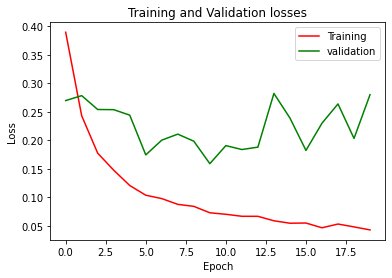

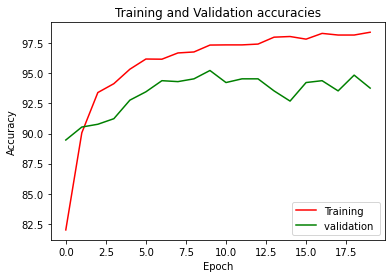

In [13]:
#plot of loss and accuracy for Efficient_GRU_Model
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))

[[774  42]
 [ 39 445]]


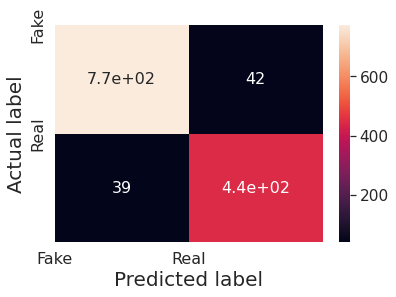

True positives =  774
False positives =  42
False negatives =  39
True negatives =  445


Accuracy:  93.76923076923077
Precision:  0.9485294117647058
Recall:  0.9520295202952029


In [14]:
#Confusion Matrix for Efficient_GRU_Model
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

In [15]:
test_data = VideoDataset(test_df, frames_to_use = 30, im_size=112, transform = test_transforms(112))
tst_loader = DataLoader(test_data, batch_size = 2, shuffle = True, num_workers = 0)
criterion = nn.CrossEntropyLoss().cuda()
true,pred,tl,t_acc = run_inference(model2,tst_loader,criterion)

  0%|          | 0/1688 [00:00<?, ?it/s]


Accuracy 91.85185185185185


[[2541  229]
 [  46  559]]


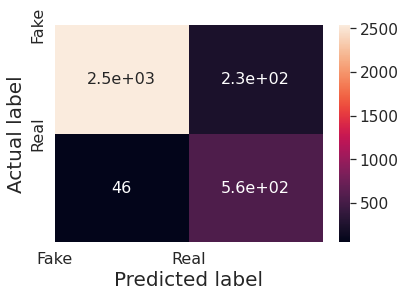

True positives =  2541
False positives =  229
False negatives =  46
True negatives =  559


Accuracy:  91.85185185185185
Precision:  0.9173285198555957
Recall:  0.9822187862388867


In [16]:
print(confusion_matrix(true,pred)) 
print_confusion_matrix(true,pred) 